In [1]:
import inference_helpers

import torch
from config import get_config

from sklearn.metrics import mean_squared_error

In [122]:
from importlib import reload
reload(inference_helpers)

<module 'inference_helpers' from 'c:\\Users\\obhlivoj\\DP\\System-Imbalance-Forecasting\\models\\transformer\\inference_helpers.py'>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
cfg = get_config()

import numpy as np

num_models = 1
path_pre = './loss/runforward_'

Using device: cuda


In [3]:
params = ['d_ff', 'Nx', 'n_head', 'dropout']

In [4]:
best_metrics, best_models_inds, data_dict = inference_helpers.get_best_model(cfg, './loss/runforward_', num_models = 1)
loss_validation, loss_cat, preds_gt = inference_helpers.validate_n_models(device, 'forward_', params, best_models_inds, eval_data="val")

MODEL EVAL - #1
--------------------


100%|██████████| 14/14 [00:01<00:00,  9.03it/s]

--------------------
Time-step	Error
1		19803.09
2		24795.09
3		26466.05
4		26583.06
5		28296.31
6		28961.32
7		29207.99
8		29112.62


In [5]:
res = inference_helpers.compute_val_errors(preds_gt, num_models = 8)

Step	RMSE	MAE	R2
1	140.72	102.22	0.35
2	157.46	116.24	0.18
3	162.68	120.11	0.13
4	163.04	120.39	0.12
5	168.22	124.29	0.07
6	170.18	125.65	0.05
7	170.90	126.14	0.04
8	170.62	125.76	0.04


In [6]:
loss_validation, loss_cat, preds_gt = inference_helpers.validate_n_models(device, 'forward_', params, best_models_inds, eval_data="test")

MODEL EVAL - #1
--------------------


100%|██████████| 14/14 [00:01<00:00,  8.44it/s]


--------------------
Time-step	Error
1		17331.63
2		22119.11
3		24324.29
4		25087.64
5		26557.32
6		27226.53
7		27642.83
8		27619.60


In [7]:
res = inference_helpers.compute_val_errors(preds_gt, num_models = 8)

Step	RMSE	MAE	R2
1	131.65	94.40	0.36
2	148.72	108.03	0.18
3	155.96	113.48	0.10
4	158.39	114.90	0.07
5	162.96	118.35	0.02
6	165.00	119.54	-0.01
7	166.26	120.56	-0.02
8	166.19	120.28	-0.02


In [8]:
seq_data = inference_helpers.group_data(preds_gt)

rmse_data = np.empty(len(seq_data), dtype=np.float32)
for ind, dp in enumerate(seq_data):
    rmse_data[ind] = mean_squared_error(dp['true'], dp['pred'], squared=False)

# get k random, best and worst predictions
k = 3
min_loss_inds = np.argsort(rmse_data)[:k].tolist()
max_loss_inds = np.argsort(rmse_data)[-k:].tolist()
rand_inds = np.random.randint(0, len(rmse_data), size=k).tolist()

### Bad predictions

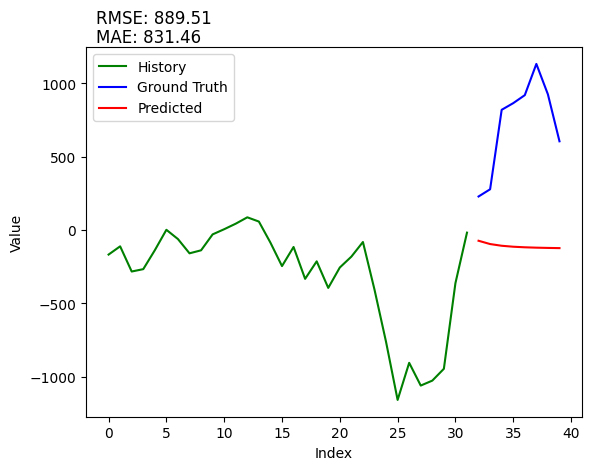

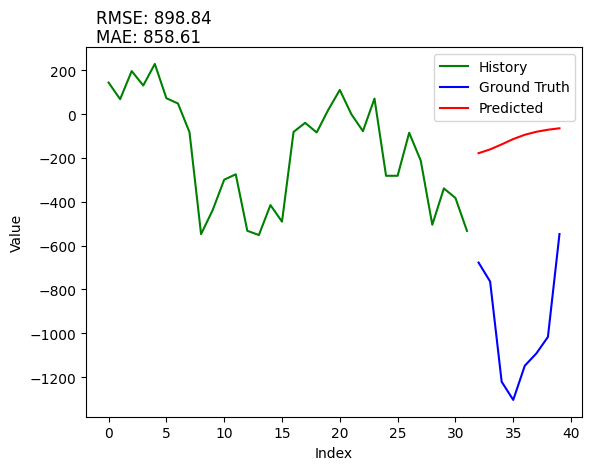

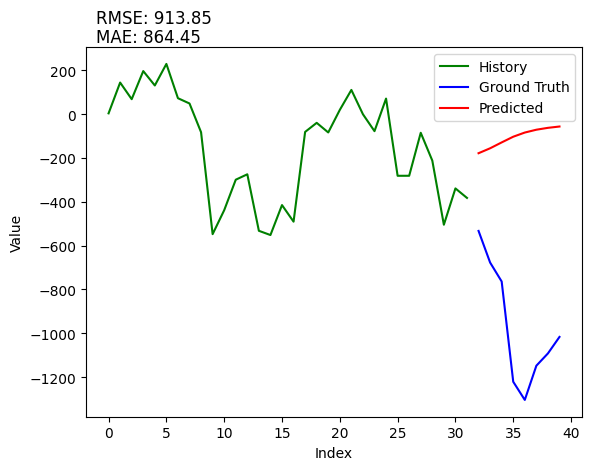

In [124]:
inference_helpers.plot_k_results(seq_data, max_loss_inds)

### Good predictions

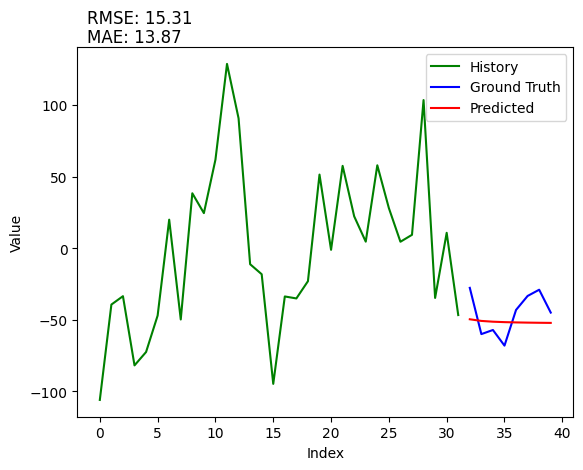

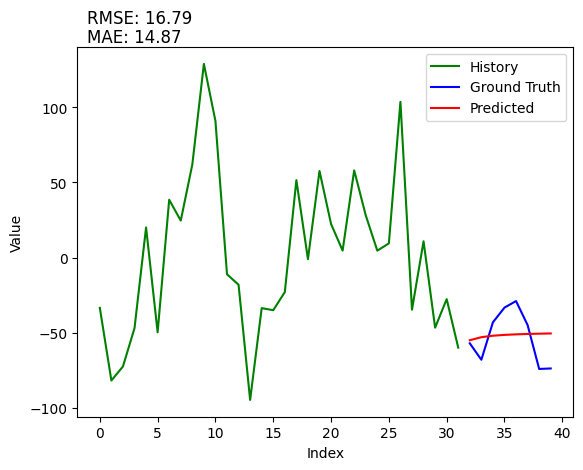

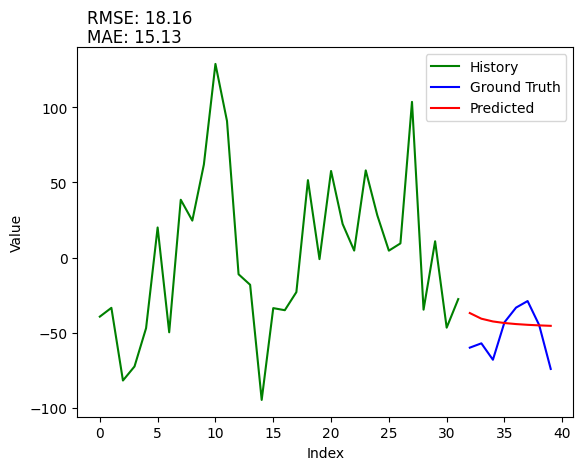

In [125]:
inference_helpers.plot_k_results(seq_data, min_loss_inds)

### Random predictions

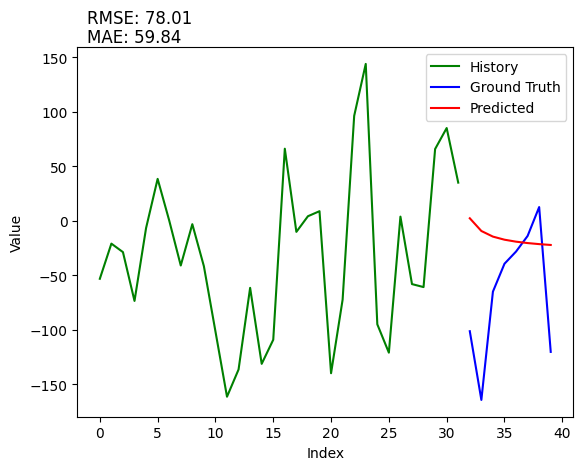

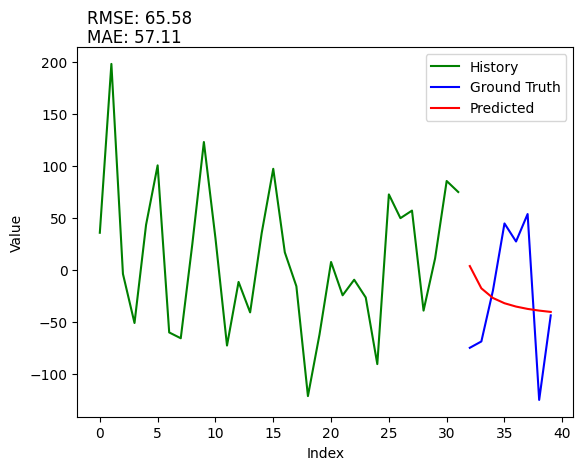

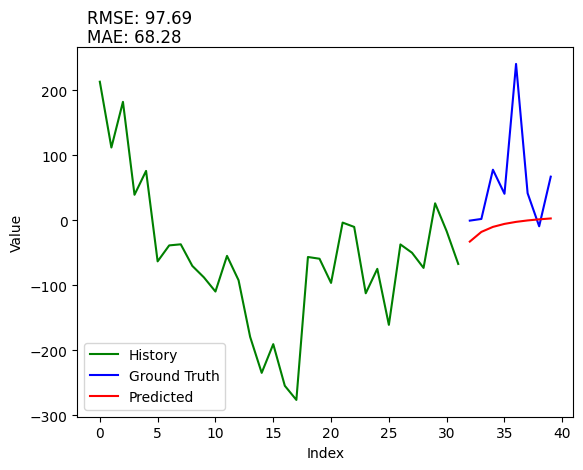

In [126]:
inference_helpers.plot_k_results(seq_data, rand_inds)